In [1]:
%run 'Functions.ipynb'

In [2]:
def hist_terms(terms=None, interval='week', start='1900-01-01', end='2020-01-01'):
    q = Search(index='hep-analysis')[0:0]
    if terms:
        q = q.query('match_phrase', **{'abstracts.value': terms})
    q = q.filter('range', earliest_date={'gte': start, 'lt': end})
    q.aggs.bucket(
        'group_by_date', 
        'date_histogram', 
        field='earliest_date', 
        interval=interval,
        format='date_optional_time'
    )
    return q.execute().aggregations.group_by_date.buckets

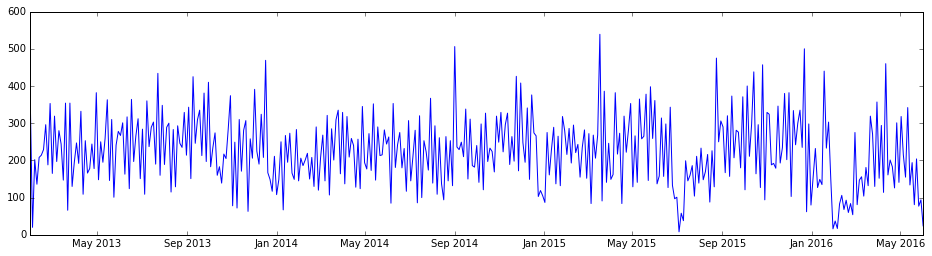

In [3]:
tx, ty = unzip(hist_terms(interval='3d'))
plt.plot(tx, ty)

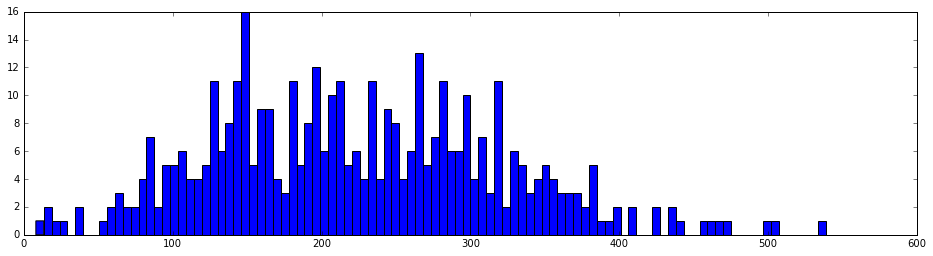

In [4]:
plt.hist(ty, bins=100)
plt.show()

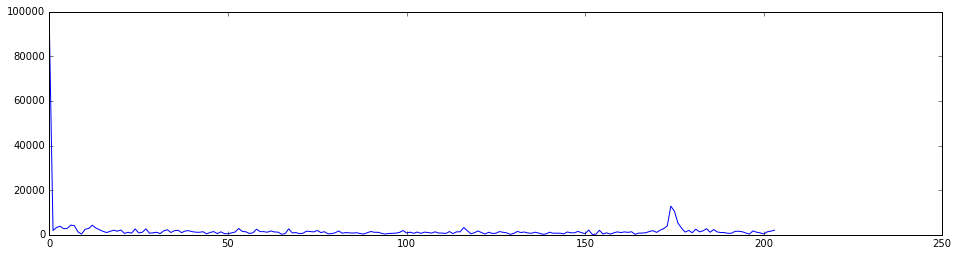

In [5]:
plt.plot(np.abs(np.fft.rfft(ty)))

In [6]:
fft = np.abs(np.fft.rfft(ty))
fft[fft < 12000] = 0

In [7]:
days = (max(tx)-min(tx)).days
days

1218

In [8]:
np.argsort(-fft)[:5]

array([  0, 174, 130, 131, 132])

In [9]:
np.nonzero(fft)

(array([  0, 174]),)

In [10]:
1 / (np.nonzero(fft)[0][1:] / days)

array([ 7.])

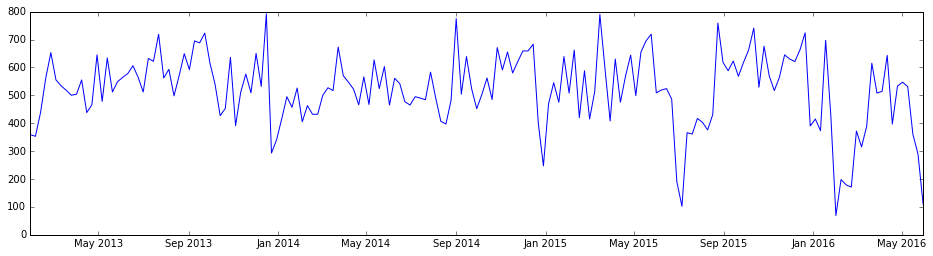

In [11]:
tx, ty = unzip(hist_terms())
plt.plot(tx, ty)

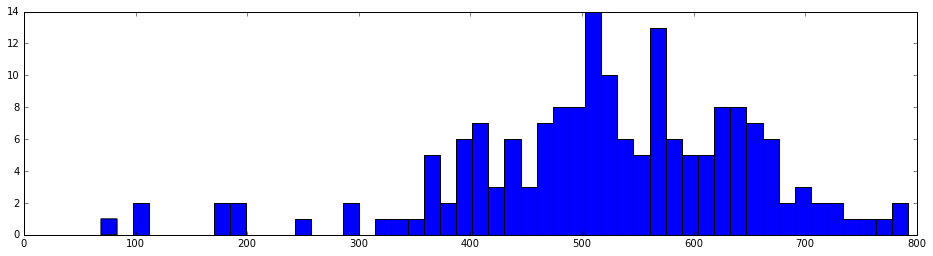

In [12]:
plt.hist(ty, bins=50)
plt.show()

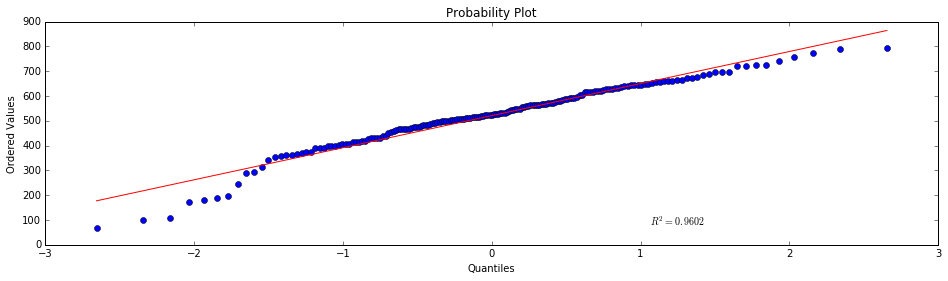

In [13]:
sp.stats.probplot(ty, dist="norm", plot=py)
py.show()

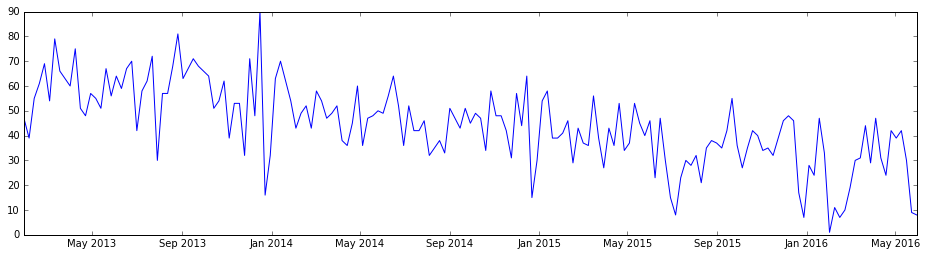

In [14]:
x, y = unzip(hist_terms('galaxy'))
plt.plot(x, y)

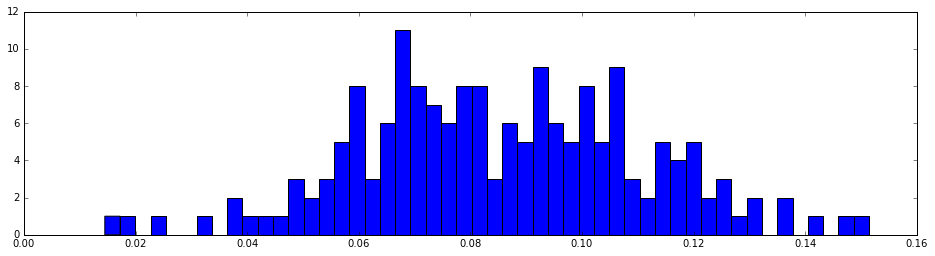

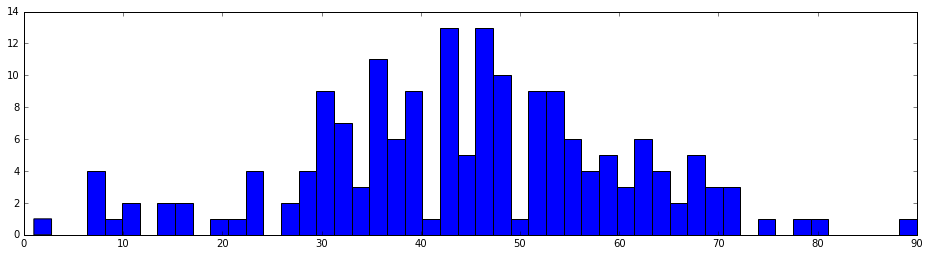

In [15]:
plt.hist(zero_div(y, ty), bins=50)
plt.show()
plt.hist(y, bins=50)
plt.show()

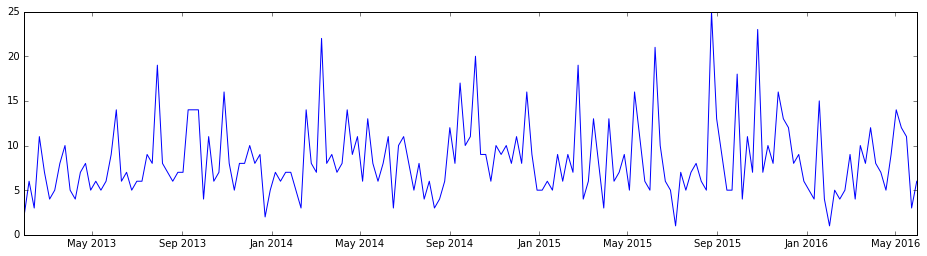

In [16]:
x, y = unzip(hist_terms('laser'))
plt.plot(x, y)

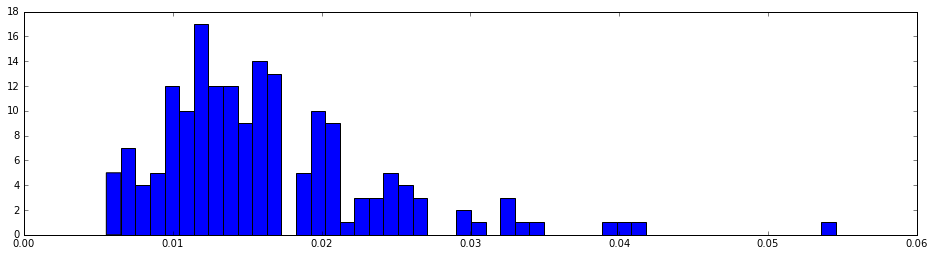

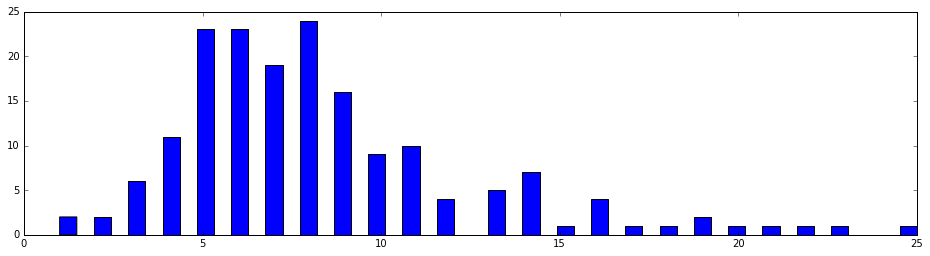

In [17]:
plt.hist(zero_div(y, ty), bins=50)
plt.show()
plt.hist(y, bins=50)
plt.show()

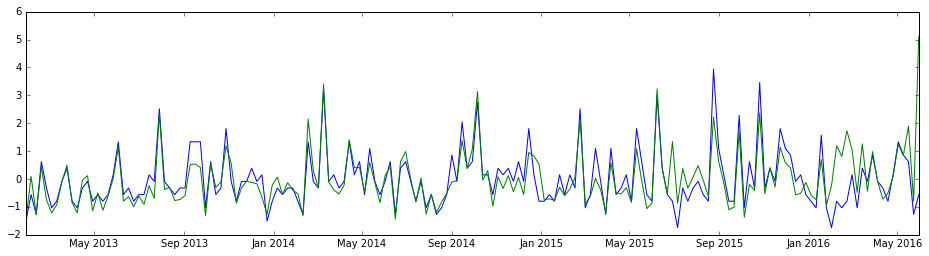

In [18]:
plt.plot(x, sp.stats.zscore(y), label='raw zscore')
plt.plot(x, sp.stats.zscore(zero_div(y, ty)), label='norm. zscore')
#plt.legend()

In [19]:
def zscore_plot(terms, normed=False):
    tx, ty = unzip(hist_terms())
    x, y = unzip(hist_terms('neutrino'))
    plt.plot(x, y)

In [20]:
id_week1 = interval_ids('2013-03-01')
id_week2 = interval_ids('2013-03-08')
id_week3 = interval_ids('2013-03-15')
id_week4 = interval_ids('2013-03-22')

In [21]:
terms_week1 = fold_vectors(term_vectors(id_week1, 'abstracts.value'))
terms_week2 = fold_vectors(term_vectors(id_week2, 'abstracts.value'))
terms_week3 = fold_vectors(term_vectors(id_week3, 'abstracts.value'))
terms_week4 = fold_vectors(term_vectors(id_week4, 'abstracts.value'))

In [22]:
terms_week1['higg']

{'doc_freq': 49, 'doc_total': 961, 'term_freq': 454, 'term_total': 7009}

In [23]:
terms_week2['higg']

{'doc_freq': 24, 'doc_total': 930, 'term_freq': 215, 'term_total': 6786}

In [24]:
terms_week3['higg']

{'doc_freq': 25, 'doc_total': 977, 'term_freq': 266, 'term_total': 7123}

In [25]:
terms_week4['higg']

{'doc_freq': 33, 'doc_total': 930, 'term_freq': 256, 'term_total': 6786}

In [26]:
selected = {}
for k, v in sorted(terms_week1.items()):
    if v['doc_freq'] >= 5:
        selected[k] = v

In [27]:
len(selected)

1910

In [28]:
def align_origin(ax1, ax2):
    _, y1 = ax1.transData.transform((0, 0))
    _, y2 = ax2.transData.transform((0, 0))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1 - y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny + dy, maxy + dy)


In [106]:
spiky = []
for k, v in list(selected.items()):
    hist = hist_terms(k)
    if len(hist):
        x, y = unzip(hist_terms(k))
        start = np.where(tx == min(x))[0][0]
        end = np.where(tx == max(x))[0][0]
        scoped = ty[start:end+1]
        normalized = zero_div(y, scoped)
        zscore = sp.stats.zscore(normalized)
        chiscore = (normalized - np.mean(normalized)) ** 2 / np.mean(normalized) * 100

        if v['doc_freq'] >= 10:
            for index in np.where(zscore >= 4)[0]:
                spiky.append((x[index], k))

            #plot_scores(normalized, (zscore, 'zscore'), (chiscore, 'chiscore'))
            #plt.hist(score)

In [30]:
"%f%%" % ((1 - sp.stats.norm.cdf(4)) * 100)

'0.003167%'

In [107]:
len(spiky)

259

In [108]:
trends = {}
for k, v in spiky:
    date = k.strftime("%Y-%m")
    if date in trends:
        trends[date].append(v)
    else:
        trends[date] = [v]


In [120]:
for date, terms in sorted(trends.items()):
    print(date)
    print(', '.join(sorted(list(set(terms)))))
    print()

2013-01
constrain, generally, narrow, population, power

2013-02
evolution, sight

2013-03
anisotropy, catalog, cms detector, data sample, extinction, light curve, map, parameter, pp collision, respectively, significance, spectrum, standard deviation, statistic

2013-04
blue, cool, day, peak

2013-05
blue, especially, typical

2013-06
consequence, equal

2013-07
cp violate, observatory, telescope, top, top quark

2013-08
infrared

2013-09
dwarf, member, near infrared

2013-10
publish

2013-11
fixed, gauge theory, lattice

2013-12
electric

2014-02
kind, must, reproduce

2014-03
luminos, plasma

2014-05
collision, rapid

2014-07
small scale

2014-08
underlying

2014-10
lattice

2014-11
lattice, meson, qcd

2014-12
cluster, ground, radio, temperature

2015-01
reaction, understanding

2015-02
shell

2015-03
delta, luminos

2015-05
cosmic, gamma, gamma ray, high energy, ray

2015-06
call, compatible, detector, performance, photon, phy, probability, resolution, statistic, transient

2015-07

In [56]:
def plot_scores(data, *scores):
    fig, ax1 = plt.subplots()
    for score, label in scores:
        ax1.plot(x, score , label=label)
    plt.legend()
    ax2 = ax1.twinx()
    ax2.fill_between(x, 0, data - np.ones(len(data)) * np.mean(data), facecolor='lightgrey', alpha=0.3)
    align_origin(ax1, ax2)
    plt.show()

In [ ]:
def repeat_sides(num, arr):
    arr = np.array(arr)
    left = np.ones(num) * arr[0]
    right = np.ones(num) * arr[-1]
    return np.append(left, np.append(arr, right))

In [121]:
data = repeat_sides(3, y)
spl = sp.interpolate.InterpolatedUnivariateSpline(range(len(data)), data)
inter = np.arange(0, len(data), 0.1)
#plt.plot(inter, spl(inter))
plt.fill_between(inter, 0, spl(inter), facecolor='lightgrey', alpha=0.3)
plt.plot(data)

NameError: name 'repeat_sides' is not defined